# Aghast Example

In [1]:
import numpy as np
import boost_histogram as bh
import ROOT
import aghast
import uproot
import os
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.20/04


[ROOT](https://root.cern/) is a scientific software toolkit popular in HEP. Format conversion between ROOT and boost-histogram can be performed by Scikit-HEP tools. [Aghast](https://github.com/scikit-hep/aghast) is a histogramming library to provide better communication between histogramming libraries, instead of filling or plotting them. Here, you can see how to convert between ROOT and boost-histogram by Aghast. 

> ### Note:
>
> Importing ROOT interferes with Jupyter/IPython, causing tab completion to break and "X is not defined" to be printed out ad-nauseam to the terminal. Sorry. Many cases can be handled by uproot, which avoids this dependency and irritaiton.

## boost-histogram to ROOT via ROOT

Let's start with a boost-histogram:

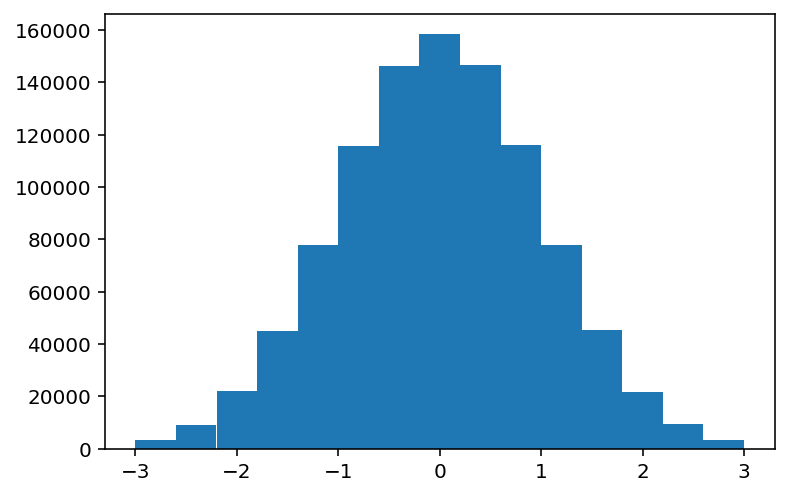

In [2]:
h = bh.Histogram(bh.axis.Regular(15, -3, 3))
h.fill(np.random.normal(size=1_000_000))

# Quick plot
plt.bar(h.axes[0].centers, h, h.axes[0].widths);

If you want a ROOT histogram from boost-histogram object, convert the boost-histogram object to an Aghast histogram at first, and then convert the Aghast histogram to ROOT histogram. We currently need to use to/from numpy to communicate between the libraries (don't worry, a copy is not made).

In [3]:
ghastly_hist = aghast.from_numpy(h.to_numpy())
ghastly_hist

Now let's write this with ROOT. Notice that ROOT uses a stateful global interface, so we open a file, we make a new object, then we save the file - the object is created in the open file "magically". (Does this sound like a problem for things like threading? Yes, it is. It's going away in ROOT 7 eventually.)

In [4]:
file = ROOT.TFile("demo_root_hist.root", "RECREATE")
root_hist = aghast.to_root(ghastly_hist, "root_hist")
file.Write()

344

Now, let's open the file with uproot:

In [5]:
rf = uproot.open("demo_root_hist.root")
th1 = rf['root_hist']

You can see that these are *similar*, though aghast doesn't handle the overflow bins in the numpy format yet:

In [6]:
th1.allnumpy()

(array([     0.,   3178.,   9107.,  22040.,  44873.,  77737., 115768.,
        146174., 158248., 146594., 115872.,  77762.,  45480.,  21799.,
          9379.,   3300.,      0.]),
 array([-inf, -3. , -2.6, -2.2, -1.8, -1.4, -1. , -0.6, -0.2,  0.2,  0.6,
         1. ,  1.4,  1.8,  2.2,  2.6,  3. ,  inf]))

In [7]:
h.to_numpy()

(array([  3178.,   9107.,  22040.,  44873.,  77737., 115768., 146174.,
        158248., 146594., 115872.,  77762.,  45480.,  21799.,   9379.,
          3300.]),
 array([-3. , -2.6, -2.2, -1.8, -1.4, -1. , -0.6, -0.2,  0.2,  0.6,  1. ,
         1.4,  1.8,  2.2,  2.6,  3. ]))

## boost-histogram to ROOT via uproot

If you want to save and load simple ROOT histograms, [uproot](https://github.com/scikit-hep/uproot) is able to read and write direcly in Numpy format:

In [9]:
root_file = uproot.recreate("demo_uproot_file.root")
root_file['words'] = 'See What\'s in the ROOT File!'
root_file['hist'] = h.to_numpy()

Did you notice something? There is no `.close()` or context manager here. Uproot 3 closes the file after every operation. Context managers will be available in Uproot 4.

Let's reopen the file:

In [10]:
root_file2 = uproot.open("demo_uproot_file.root")
print(root_file2['words'])
root_file2['hist'].show()

See What's in the ROOT File!
                        0                                             1.6616e+05
                        +------------------------------------------------------+
[-inf, -3)   0          |                                                      |
[-3, -2.6)   3178       |*                                                     |
[-2.6, -2.2) 9107       |***                                                   |
[-2.2, -1.8) 22040      |*******                                               |
[-1.8, -1.4) 44873      |***************                                       |
[-1.4, -1)   77737      |*************************                             |
[-1, -0.6)   1.1577e+05 |**************************************                |
[-0.6, -0.2) 1.4617e+05 |************************************************      |
[-0.2, 0.2)  1.5825e+05 |***************************************************   |
[0.2, 0.6)   1.4659e+05 |************************************************      |

## ROOT to boost-histogram

Similarly, you can convert a ROOT histogram to boost-histogram histogram. *Note that you cannot get access to the the centers of Aghast axes edges, so we need to calculate it manually.* This should be better in future versions.

<BarContainer object of 30 artists>

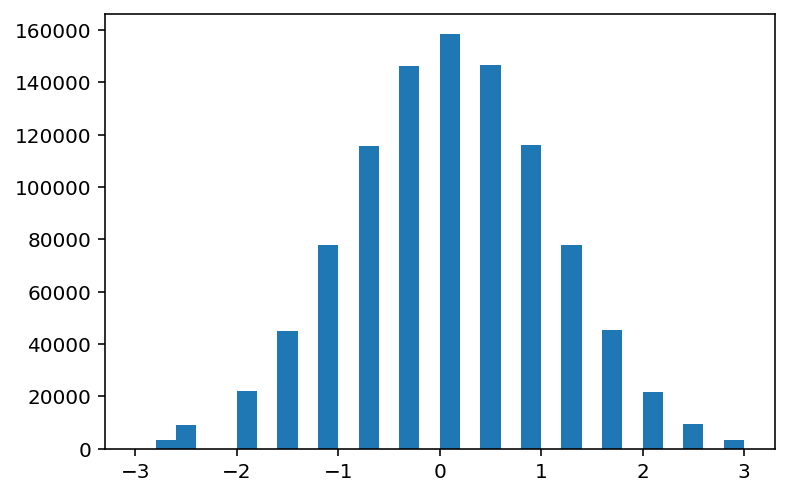

In [11]:
ghastly_hist = aghast.from_root(root_hist)
w, data = aghast.to_numpy(ghastly_hist)

h = bh.Histogram(bh.axis.Regular(30, -3, 3))
centers = [(data[idx] + data[idx+1]) / 2 for idx in range(len(data) - 1)]
h.fill(centers, weight=w)
plt.bar(h.axes[0].centers, h.view(), width=h.axes[0].widths);